In [126]:
#imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn as skl
import tensorflow as tf
import math
from os import listdir
from math import e

2.718281828459045


In [156]:
#defining a method which returns the original oil in place for a well
def get_ooip(file):
    well_name = file[:-4]
    well_df = pd.read_csv(file)
    well_prod_info = well_production.loc[well_production['well name'] == well_name]
    area = 360*640#(well_df['easting'].max()-well_df['easting'].min())*(well_df['northing'].max()-well_df['northing'].min())/43560
    thickness = well_df['thickness (ft)'].mean()
    porosity = well_df.porosity.mean()
    water_saturation = well_df['water saturation'].mean()
    formation_volume_factor = well_production['formation volume factor'].mean()
    ooip = (7758*area*thickness*porosity*(1-water_saturation))/(formation_volume_factor)
    return ooip
#defining a method which returns the recoverable reserves of a well
def get_recov_reserves(file):
    well_name = file[:-4]
    well_df = pd.read_csv(file)
    well_prod_info = well_production.loc[well_production['well name'] == well_name]
    recov_reserves = get_ooip(file)*well_production.loc[well_production['well name'] == well_name, 'recovery factor']
    return float(recov_reserves)
#defining a method which returns the rate of initial production of a well
def get_init_prod_rate(file):
    well_name = file[:-4]
    well_df = pd.read_csv(file)
    well_prod_info = well_production.loc[well_production['well name'] == well_name]
    init_prod = well_production.loc[well_production['well name'] == well_name, 'oil 1']/30
    cur_prod = well_production.loc[well_production['well name'] == well_name, 'oil 12']/30
    q1 = well_production.loc[well_production['well name'] == well_name, 'cum. oil prod. (year 1)']/360
    decl_rate = ((init_prod-cur_prod)/init_prod)
    init_prod_rate = q1*e**(decl_rate)
    return float(init_prod_rate)
#defining a method which returns the life of reservoir for a well
def get_reservoir_life(file):
    well_name = file[:-4]
    well_df = pd.read_csv(file)
    well_prod_info = well_production.loc[well_production['well name'] == well_name]
    return 0
#defining a method which returns the cumulative production of a well
def get_cum_prod(file):
    well_name = file[:-4]
    well_df = pd.read_csv(file)
    well_prod_info = well_production.loc[well_production['well name'] == well_name]
    init_prod = well_production.loc[well_production['well name'] == well_name, 'oil 1']/30
    cur_prod = well_production.loc[well_production['well name'] == well_name, 'oil 12']/30
    decl_rate = ((init_prod-cur_prod)/init_prod)
    i_prod = get_init_prod_rate(file)
    q1 = well_production.loc[well_production['well name'] == well_name, 'cum. oil prod. (year 1)']/360
    cum_prod = (i_prod/decl_rate)*np.log(i_prod/q1)*360
    return float(cum_prod)

In [127]:
#making a class with which to objectify and instantiate wells
class Well():
    #constructor
    def __init__(self, well_name, ooip, recov_reserves, init_prod_rate, reservoir_life, cum_prod):
        self.well_name = well_name
        self.well_dataframe = pd.read_csv(well_name)
        self.ooip = ooip
        self.recov_reserves = recov_reserves
        self.init_prod_rate = init_prod_rate
        self.reservoir_life = reservoir_life
        self.cum_prod = cum_prod
        
    #getter methods
    def get_ooip():
        return ooip
    def get_recov_reserves():
        return recov_reserves
    def get_init_prod_rate():
        return init_prod_rate
    def get_reservoir_life():
        return reservoir_life
    def get_cum_prod():
        return cum_prod

In [157]:
#creating a list of the data's .csv file names
well_data_files = [file for file in listdir(os.getcwd()) if file.endswith('.csv') and file != 'well production.csv']

#creating a list of well objects
wells = []
for file in well_data_files:
    wells.append(Well(file, get_ooip(file), get_recov_reserves(file), get_init_prod_rate(file), get_reservoir_life(file), get_cum_prod(file)))
    
#creating a well production dataframe
well_production = pd.read_csv('well production.csv')

#adding OOIP, Recoverable Reserves, Rate of Init. Production, Life of Reservoir, & Cum. Production columns
ooip = []
recov_reserves = []
init_prod_rate = []
life_of_reservoir = []
cum_prod = []
for well in wells:
    ooip.append(well.ooip)
    recov_reserves.append(well.recov_reserves)
    init_prod_rate.append(well.init_prod_rate)
    life_of_reservoir.append(well.reservoir_life)
    cum_prod.append(well.cum_prod)
well_production['ooip'] = ooip
well_production['recoverable reserves'] = recov_reserves
well_production['init. prod. rate'] = init_prod_rate
well_production['life of reservoir'] = life_of_reservoir
well_production['cum. production'] = cum_prod

well_production['cum. oil prod. (year 1)'] = well_production.iloc[:,4:16].sum(axis=1)

well_production.head()

,well name,average pressure (Pa),recovery factor,formation volume factor,oil 1,oil 2,oil 3,oil 4,oil 5,oil 6,...,water 9,water 10,water 11,water 12,ooip,recoverable reserves,init. prod. rate,life of reservoir,cum. production,cum. oil prod. (year 1)
0,Peak 6-217H,35352874,0.092554,1.6,862.0,824.0,759.0,728.0,661.0,601.0,...,547.0,562.0,639.0,668.0,2.613877e+09,2.802451e+08,11.956330,0,4304.278947,6808.0
1,Tarragon 4-119H,34882173,0.107706,1.6,228.0,249.0,214.0,210.0,161.0,163.0,...,124.0,119.0,126.0,157.0,2.465997e+08,1.778070e+07,1.293059,0,465.501160,1968.0
2,Fennel 10-129H,36064538,0.079150,1.6,67.0,85.0,73.0,73.0,57.0,58.0,...,20.0,49.0,30.0,41.0,4.882912e+09,4.756674e+08,23.004584,0,8281.650190,736.0
3,Federal 14-113H,35817881,0.103748,1.6,256.0,242.0,267.0,263.0,199.0,191.0,...,139.0,162.0,136.0,183.0,1.169427e+09,9.971056e+07,5.386706,0,1939.214246,2204.0
4,King 7-184H,38442406,0.084675,1.6,23.0,29.0,31.0,50.0,72.0,52.0,...,0.0,0.0,7.0,0.0,3.255969e+09,2.588415e+08,2.965093,0,1067.433411,490.0


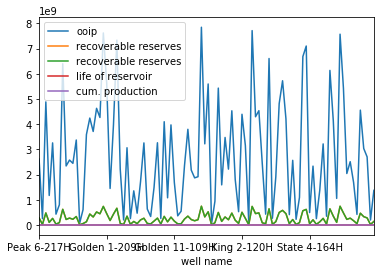

In [154]:
#plotting well data
ax = plt.gca()

well_production.plot(kind='line', x='well name', y='ooip', ax=ax)
well_production.plot(kind='line', x='well name', y='recoverable reserves', ax=ax)
well_production.plot(kind='line', x='well name', y='init prod rate', ax=ax)
well_production.plot(kind='line', x='well name', y='life of reservoir', ax=ax)
well_production.plot(kind='line', x='well name', y='cum. production', ax=ax)

plt.show()